In [1]:
import keras

2024-05-25 16:02:13.314776: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 16:02:13.318303: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-25 16:02:13.361411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 16:02:14.188946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Adesso posso caricare il modello addestrato in precedenza e preoccuparmi semplicemente dell'output dell'ultima rete convoluzionale. Dal summary si può notare che l'ultima layer convoluzionale emette 500 valori relativi alle attivazioni, questi saranno quindi le feature del nostro nuovo modello.

In [2]:
model = keras.saving.load_model("../models/modello-passi.keras")
attivazioni = keras.Model(inputs=model.layers[0].output,outputs=model.layers[6].output)
attivazioni.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 50, 20)         │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 50, 20)         │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 50, 10)         │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 500)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,730 (10.66 KB)

 Trainable params: 2,730 (10.66 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
import pandas as pd

dati = pd.read_csv("../data/valutati.csv.gz")[:100000]

Questa sotto è una visualizzazione delle attivazioni della rete in risposta all'input mostrato

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


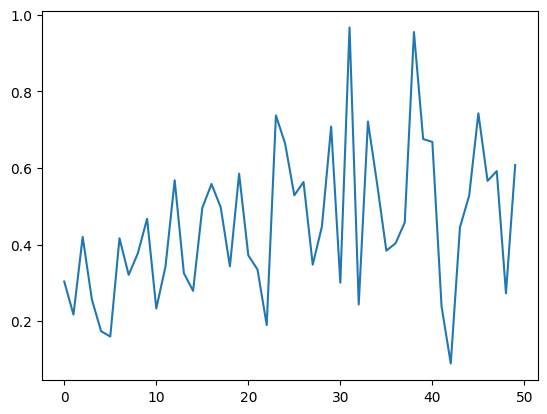

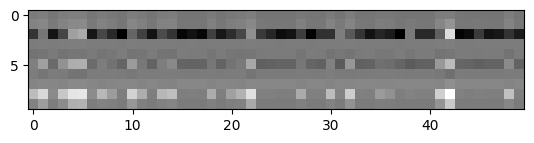

In [7]:
import matplotlib.pyplot as plt

window=50

for uuid,group in dati.groupby('uuid'):
    if len(group)<window:
        continue
    inp = group["user_minmax_steps"].values[-window:].reshape(50,1)
    pred= attivazioni.predict(inp)
    plt.plot(inp, label='Truth')
    plt.show()
    plt.close()
    plt.imshow(pred.reshape(50,10).T,cmap='Greys')
    plt.show()
    plt.close()
    break

Preparo di nuovo i dati dei passi che dovrò dare in pasto alla rete per ottenere le attivazioni. Quelle attivazioni saranno poi i dati di training per il prossimo modello.

In [27]:
import numpy as np

xtrain = []
ytrain = []
xtest=[]
ytest=[]
window=50
test_ratio=0.1
for uuid, group in dati.groupby('uuid')[["user_minmax_steps","sleep_quality_score"]]:
    split=int(len(group)*(1-test_ratio))
    if split<window:
        continue
        
    inputs = np.array(group["user_minmax_steps"].values)
    output = np.array(group["sleep_quality_score"].values)


    for i in range (window,split):
        xtrain.append(inputs[i-window:i]) # Una finestra di <window> osservazioni sui passi
        ytrain.append(output[i]) # La qualità del sonno alla fine della finestra

    for i in range (split,len(group)):
        xtest.append(inputs[i-window:i])
        ytest.append(output[i])

xtrain=np.array(xtrain).reshape(-1,window,1)
ytrain=np.array(ytrain).reshape(-1,1)
xtest=np.array(xtest).reshape(-1,window,1)
ytest=np.array(ytest).reshape(-1,1)

Converto le osservazioni sui passi in una serie di attivazioni, da usare come input per il modello. Visto che 500 sono un po' tante ho provato anche a ridurre la dimensionalità con PCA

In [38]:
attivazioni_train = attivazioni.predict_on_batch(xtrain).reshape(-1,500)
attivazioni_test = attivazioni.predict_on_batch(xtest).reshape(-1,500)

In [39]:
from sklearn.decomposition import PCA

pca= PCA(n_components=.95)

attivazioni_train=pca.fit_transform(attivazioni_train)
attivazioni_test= pca.transform(attivazioni_test)
attivazioni_train

array([[ 0.08498394, -0.3576034 ,  0.5390247 , ...,  0.04984998,
         0.06832226, -0.07382023],
       [ 0.08221686, -0.28617352,  0.5582867 , ...,  0.205972  ,
        -0.09035961, -0.01177979],
       [ 0.163315  , -0.18392465,  0.43793178, ...,  0.01456038,
         0.03927362,  0.13754465],
       ...,
       [-1.0431703 , -0.05443899,  0.02870988, ...,  0.00628539,
        -0.05968728, -0.11177687],
       [-1.0532036 , -0.05769584,  0.07264068, ..., -0.04914398,
        -0.05950337,  0.1532985 ],
       [-1.0870934 , -0.01430172,  0.14727405, ...,  0.07311054,
         0.16525835, -0.09644767]], dtype=float32)

In [40]:
ytest=ytest.reshape(-1)
ytrain=ytrain.reshape(-1)
ytrain

array([0.58212721, 0.51416949, 0.58207697, ..., 0.45932754, 0.53146082,
       0.64502519])

Provo con un Percettrone multistrato

In [41]:
from sklearn.neural_network import MLPRegressor

regressore = MLPRegressor()
regressore.fit(attivazioni_train,ytrain)

MLPRegressor()

In [42]:
regressore.score(attivazioni_test,ytest)

-0.019174676453946438

In [43]:
regressore.predict([attivazioni_test[0]])

array([0.5671904], dtype=float32)

In [44]:
ytest[0]

0.4104164785553047